# Tarea: Analisis exploratorio con Topic Modeling
##### _Sebastián Pacheco Cáceres - Oct 2022_

El presente trabajo consta de identificar los tópicos más relevantes de cada comuna en la Región de Los Lagos.

Los datos corresponden a noticias de todo el mes de junio de 2021 (30 días) para un listado de medios periodísticos listados más abajo, con un total de 2413 noticias válidas (con texto no-nulo).

Solo tomando las comunas, quedan 1123 noticias sin clasificar. Esto motivó el desarrollo de un filtro más complejo para identificar localidades cercanas o si es que la noticia habla de un tema nacional.P ara identificar los patrones relevantes, revisé ~50 noticias manualmente en busca de palabras claves.

Finalmente quedaron 260 noticias sin reconocer, donde el tag mayoritariamente encontrado es Chile, lo que posiblemente indica que corresponden a noticias nacionales (no-locales).

In [39]:
from funcionesTarea01 import *
import importlib
from datetime import datetime
from pandasql import sqldf
from spacy.matcher import PhraseMatcher, Matcher
import elasticsearch
import geopandas as gpd
import numpy as np
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models

nlp = spacy.load('es_core_news_sm')

IP = "search.sophia2.org"
PORT = 9200
USER = "elastic"
PASS = "dummy_elastic"

es = elasticsearch.Elasticsearch(
    f"http://{IP}:{PORT}",
    http_auth=(USER, PASS)
)

country = "chile"
from_ = "2021-06-01"
to_ = "2021-06-30"
media_outlets = ["elllanquihue", "elaustral", "laestrelladechiloe", "elheraldoaustral", "radiosago",
                 "elrepuertero", "elvacanudo", "elhuemul", "seminariolocal", "elquellonino", "elinsular",
                 "radiopudeto", "radioacogida", "elcalbucano", "segundos33",
                 "prensadelestuario", "fresiaahora", "soychiloe"]

comunas = [
    "ancud", "castro", "chonchi", "curaco de vélez", "dalcahue",
    "puqueldón", "queilén", "quemchi", "quellón", "quinchao", "calbuco",
    "cochamó", "fresia", "frutillar", "llanquihue", "los muermos", "maullín",
    "puerto montt", "puerto varas", "osorno", "puerto octay", "purranque",
    "puyehue", "río negro", "san juan de la costa", "san pablo", "chaitén",
    "futaleufú", "hualaihué", "palena",
]

headers = {'id_news': [], 'country': [], 'media_outlet': [],
           'url': [], 'title': [], 'text': [], 'date': [], 'comuna': []}

query = {
    "bool": {
        "filter": [
            {"range": {
                "date": {
                    "gte": from_,
                    "lt": to_
                }}},
            {"term":  {"country": country}},
            {"terms":  {"media_outlet": media_outlets}}
        ]
    }
}

In [2]:
# ===== Matchers creation =====
com_matcher = PhraseMatcher(nlp.vocab)
com_matcher.add("cll", [nlp(comuna) for comuna in comunas])

matcher = Matcher(nlp.vocab)
matcher.add(
    "regiones_conocidas", [
        [{"NORM": "los"}, {"TEXT": {"REGEX": "[Ll]agos|[Rr]íos"}}],
    ])
matcher.add(
    "region", [
        [{"NORM": "región"}, {"NORM": "de"}],
    ])
matcher.add(
    "comuna", [
        [{"NORM": "comuna"}, {"NORM": "de"}]
    ])
matcher.add(
    "chile", [
        [{"TEXT": {"REGEX": "[Nn]aci[onal|ón]"}}],
        [{"NORM": "chile"}],
    ])

# The following rule also uses a dictionary
matcher.add(
    "localidades_comunes", [
        [{"NORM": "valdivia"}],
        [{"NORM": "chiloé"}],
        [{"NORM": "collipulli"}],
    ])
dic_loc_comunes = {
    "valdivia": "valdivia",
    "chiloé": "castro",
    "collipulli": "la araucanía",
}

matcher.add(
    "cerca_ptomontt", [
        [{"NORM": "tenglo"}],
        [{"NORM": "panitao"}],
        [{"NORM": "avenida"}, {"NORM": "austral"}],
        [{"NORM": "la"}, {"NORM": "arena"}],
        [{"NORM": "regional"}],
        [{"NORM": "comuna"}, {"TEXT": {"REGEX": "!de"}}],
        [{"NORM": "región"}, {"TEXT": {"REGEX": "!de"}}]
    ])

dic_prority = {
    "cll": 10,  # la mayor prioridad
    "regiones_conocidas": 4,
    "region": 2,
    "comuna": 2,
    "chile": 1,
    "localidades_comunes": 3,
    "cerca_ptomontt": 5,
    "otros": 0,
}

In [3]:
# Prefer to read data.csv if exists.
FETFCH_DATA = False

if FETFCH_DATA:
    res = es.search(index="news", query=query, size=6000)
    print("Son %d noticias encontradas..." % res['hits']['total']['value'])

    df = pd.DataFrame(headers)

    for hit in res['hits']['hits']:
        id_news = hit['_source']['id_news']
        country = hit['_source']['country']
        media_outlet = hit['_source']['media_outlet']
        url = hit['_source']['url']
        title = hit['_source']['title']
        text = hit['_source']['text']
        date = hit['_source']['date']
        comuna = determineComuna(text)
        df.loc[len(df.index)] = [id_news, country, media_outlet,
                                 url, title, text, date, comuna]

    df = df.drop_duplicates(subset='url', keep='first')
    df = df[df["text"].isna() == False]
    df.to_csv("./data.csv")
else:
    df = pd.read_csv("./data.csv", index_col=0)
df


,id_news,country,media_outlet,url,title,text,date,comuna
0,21889455,chile,radiosago,https://www.radiosago.cl/seguridad-publica-y-c...,Seguridad Pública y Carabineros se reúnen con ...,"Gonzalo Reyes, Subdirector de Seguridad Públi...",2021-06-26,NaN
1,21889471,chile,radiosago,https://www.radiosago.cl/dictan-veredicto-cond...,Dictan veredicto condenatorio contra acusado d...,El Tribunal Oral en lo Penal de Puerto Montt ...,2021-06-27,puerto montt
2,21889476,chile,radiosago,https://www.radiosago.cl/puerto-montt-vencio-p...,Puerto Montt venció por 3 a 2 a Unión Española...,Esta jornada Deportes Puerto Montt y Unión Es...,2021-06-27,puerto montt
3,21889504,chile,radiosago,https://www.radiosago.cl/designan-a-fiscal-jef...,Designan a Fiscal Jefe de Puerto Montt en la i...,A través de un comunicado el Ministerio Públi...,2021-06-25,puerto montt
4,21889507,chile,radiosago,https://www.radiosago.cl/a-dos-queridos-period...,"A dos queridos periodistas: Adioses, entre la ...",Por Alejandro Gutiérrez Barría.Periodista puer...,2021-06-24,puerto montt
...,...,...,...,...,...,...,...,...
5594,47518202,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/0...,Cierran causa por muerte de isleña cuyo cuerpo...,Ante el peso de las conclusiones tanatológicas...,2021-06-19,castro
5607,47518287,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/0...,"Chiloé alcanzó el 83,7% de vacunación en prime...","A un 83,7% en primeras dosis y a un 68% con el...",2021-06-24,castro
5610,47518293,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/0...,Ratifican cierre de causa por incendio y defen...,Sin el más mínimo reparo se concretó ayer el s...,2021-06-24,ancud
5611,47518295,chile,laestrelladechiloe,https://www.laestrellachiloe.cl/impresa/2021/0...,"Core advierte ""retraso"" en entrega de hospital...",Adías de que el senador opositor Rabindranath ...,2021-06-24,ancud


In [4]:
# == Example Cell ==
sample_text = df.iloc[10]["text"]
print(sample_text)
print("==========\nComuna:", determineComuna(
    sample_text, nlp, com_matcher, matcher, dic_prority, dic_loc_comunes))


Poco más de 200 familias se vieron afectadas durante la jornada de ayer luego que un camión tolva derribara al menos 10 postes del servicio eléctrico y telefonía en el sector de Mirasol, en Puerto Montt. El hecho se registró en la esquina de calle Sierra con Los Sauces en la población Mirasol, donde al menos diez los postes quedaron absolutamente inutilizados debido a que el camión siguió su trayectoria por al menos una cuadra sin que el conductor se percatara que llevaba la tolva levantada, arrastrando con ello los cables, los que iban cayendo sobre las rejas de las viviendas afectadas y también en la calzada. Cristián Arriagada, jefe de servicio al cliente de Saesa., detalló cómo se trabajó en terreno para restablecer el suministro, como asimismo pidió precaución y responsabilidad a los conductores de máquinas pesadas. En los últimos 12 meses 239 postes han sido dañados en distintos eventos, lo que equivale a 3 postes chocados cada dos días, se indicó desde la distribuidora. 
Comuna:

In [5]:
# Prefer to not update the data.csv file.
SAVE_DF = False 
if SAVE_DF:
    df.to_csv("./data.csv")

In [6]:
# === Revisión de noticias sin identificar ===
dfm = df.loc[(df["comuna"].isnull()) | (df["comuna"] == "")]
print("Comunas no-identicadas:", dfm.shape[0])
if dfm.shape[0] > 0:
    selrow = dfm.iloc[0]
    print(determineComuna(
        selrow["text"], nlp, com_matcher, matcher, dic_prority, dic_loc_comunes))
    print(selrow["media_outlet"])
    print(selrow["url"])
    print(selrow["text"])
else:
    print("no results.")


Comunas no-identicadas: 1123
puerto montt
radiosago
https://www.radiosago.cl/seguridad-publica-y-carabineros-se-reunen-con-dirigentes-vecinales-de-llanos-de-tenglo/
 Gonzalo Reyes, Subdirector de Seguridad Pública, indicó que el encuentro en el que participaron dirigentes vecinales de Llanos de Tenglo y Carabineros de la tenencia Panitao, permitió el análisis de la situaciones que en materia delincuencial preocupan a los habitantes del sector como intentos de robo, falta de iluminación en algunos sectores y presencia de desconocidos. Se precisó que Carabineros y Seguridad Pública se comprometieron a aumentar los patrullajes por el sector y mantener un estrecho contacto con los dirigentes, cuando éstos denuncien situaciones irregulares. Añadió que se trata de un trabajo estratégico territorial que se intensificará en los diferentes sectores poblacionales de la comuna, donde el alcalde Gervoy Paredes, ha demandado un trabajo coordinado con Carabineros y los dirigentes sociales, de manera

In [7]:
# ===== Celda para el testeo de determineComuna() =====
DEBUG_UPDATE = False
if DEBUG_UPDATE:
    #importlib.reload(funcionesTarea01)
    df = dfUpdateComunas(df, nlp, com_matcher, matcher, dic_prority, dic_loc_comunes)

    result = sqldf("SELECT comuna,count(*) FROM df GROUP BY comuna ORDER BY count(*) DESC")
    result

In [8]:
# ===== Celda para el testeo de determineComuna() con DataFrame =====
DEBUG_UPDATESLICE = False
if DEBUG_UPDATESLICE:
    # 1000 noticias: 100~ segundos
    LIM = [100, -1][1]

    dftransform = dfm[:LIM].copy()
    print("Original:", dftransform.shape[0])
    dftest = dfUpdateComunas(dftransform, nlp, com_matcher,
                            matcher, dic_prority, dic_loc_comunes)
    print("  Result:", dftest.shape[0])

    result = sqldf(
        "SELECT comuna,count(*) FROM dftest GROUP BY comuna ORDER BY count(*) DESC")
    result


/home/usuariop/Ramos/Magister/INFO279_2022/INFO279_TratamientoAutomaticodelLenguaje/tarea01/funcionesTarea01.py:111: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(bar_info)


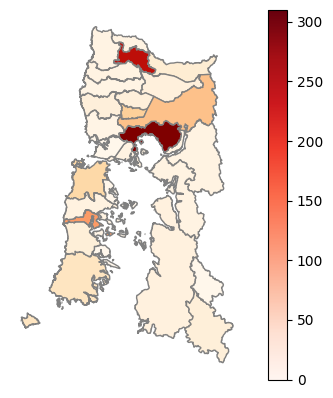

In [9]:
territory = territory_map(10)
lista =[]
n = 20
for comuna in territory["Comuna"]:
    # print(comuna)
    comdata = df[df["comuna"] == comuna.lower()]
    lista.append({"Comuna": comuna, "Valor": comdata.shape[0]})
geodf = pd.DataFrame(lista)

#save_map(geodf, territory, "Mapa")

# Análisis LDA

In [10]:
topicmatcher = Matcher(nlp.vocab)
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
topicmatcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
topicmatcher.add("NOUN-ADJ", [pattern_2])

In [27]:
# Run LDA analysis for each commune
RUN_LDA = True
if RUN_LDA:
    # 2413 noticias: 3:14 minutos
    lda_results = {}
    for comuna in comunas:
        dfcom = df[df["comuna"] == comuna]
        noticias = dfcom["text"]
        n = len(noticias)
        if n <= 1:
            print(f"Warning: {comuna} tiene {n} noticias. Saltado.")
            continue

        start = 2
        limit = min(n, 16)
        step = 2
        print(
            f"Procesando comuna: {comuna}\n",
            f"\tDesde {start} hasta {limit} cada {step}.")

        noticias_procesadas = []
        for noticia in noticias:
            noticias_procesadas.append(text_to_list(noticia, nlp, topicmatcher))
        id2word = corpora.Dictionary(noticias_procesadas)
        dataset = [id2word.doc2bow(noticia_procesada)
                   for noticia_procesada in noticias_procesadas]
        lda_results[comuna] = [id2word, dataset] + compute_coherence_values(
            dictionary=id2word, corpus=dataset, texts=noticias_procesadas, start=start, limit=limit, step=step)


Procesando comuna: ancud
 	Desde 2 hasta 16 cada 2.
Procesando comuna: castro
 	Desde 2 hasta 16 cada 2.
Procesando comuna: chonchi
 	Desde 2 hasta 16 cada 2.
Procesando comuna: curaco de vélez
 	Desde 2 hasta 12 cada 2.
Procesando comuna: dalcahue
 	Desde 2 hasta 14 cada 2.
Procesando comuna: puqueldón
 	Desde 2 hasta 5 cada 2.
Procesando comuna: quemchi
 	Desde 2 hasta 3 cada 2.
Procesando comuna: quellón
 	Desde 2 hasta 16 cada 2.
Procesando comuna: quinchao
 	Desde 2 hasta 6 cada 2.
Procesando comuna: calbuco
 	Desde 2 hasta 11 cada 2.
Procesando comuna: cochamó
 	Desde 2 hasta 11 cada 2.
Procesando comuna: fresia
 	Desde 2 hasta 16 cada 2.
Procesando comuna: frutillar
 	Desde 2 hasta 16 cada 2.
Procesando comuna: llanquihue
 	Desde 2 hasta 16 cada 2.
Procesando comuna: los muermos
 	Desde 2 hasta 8 cada 2.
Procesando comuna: maullín
 	Desde 2 hasta 2 cada 2.
Procesando comuna: puerto montt
 	Desde 2 hasta 16 cada 2.
Procesando comuna: puerto varas
 	Desde 2 hasta 16 cada 2.
Proces

In [13]:
PLOT_COHERENCE = False
if PLOT_COHERENCE:
    for comuna, [_, _, _, coherence_values] in lda_results.items():
        r = 2 + len(coherence_values) * 2
        x = range(2,  r, 2)
        plt.grid()
        plt.scatter(x, coherence_values, s=300)
        plt.xlabel("Num Topics")
        plt.ylabel("Coherence score")
        #plt.legend(("coherence_values"), loc='best')
        plt.title(comuna)
        plt.show()

In [41]:
# === Save best models ===
SAVE_BESTS = True
if SAVE_BESTS:
    dic_idxbests = {
        "ancud": 4, 
        "castro": 5,
        "chonchi": 5,
        "curaco de vélez": 2,
        "dalcahue": 4,
        "puqueldón": 0,
        "queilén": -1,
        "quemchi": 0,
        "quellón": 4,
        "quinchao": 0,
        "calbuco": 2,
        "cochamó": 2,
        "fresia": 4,
        "frutillar": 2,
        "llanquihue": 2,
        "los muermos": 1,
        "maullín": -1,
        "puerto montt": 1,
        "puerto varas": 2,
        "osorno": 5,
        "puerto octay": 3,
        "purranque": 1,
        "puyehue": 5,
        "río negro": 3,
        "san juan de la costa": 2,
        "san pablo": 2,
        "chaitén": 3,
        "futaleufú": -1,
        "hualaihué": 2,
        "palena": 2,
    }

    for comuna, [id2word, dataset, models, coherence_values] in lda_results.items():
        if len(models) == 0:
            continue
        best_model = models[dic_idxbests[comuna]]
        best_model.save(f"./modelos/{comuna}")
        pickle.dump( dataset, open(f"./modelos/{comuna}_dataset", 'wb'))

### Análisis individuales de tópicos

In [49]:
%load_ext autoreload
%autoreload 2
pyLDAvis.enable_notebook()

#dreload(funcionesTarea01)
[best_models, dic_id2word, dic_dataset] = openModels(comunas)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
queilén not founded
maullín not founded
futaleufú not founded


In [70]:
# print(len(comunas)) # 30 comunas.
comuna = comunas[0]

if comuna in best_models:
    com_model = best_models[comuna]
    com_id2word = dic_id2word[comuna]
    #print(com_id2word)
    com_dataset = dic_dataset[comuna]
    #print(com_dataset)
    vis = pyLDAvis.gensim_models.prepare(com_model, com_dataset, com_id2word)
    #pyLDAvis.display(vis, template_type='notebook')
vis

/home/usuariop/miniconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/usuariop/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/usuariop/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/usuariop/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/usuariop/miniconda3/lib/python3.9/site-

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.015086  0.078781       1        1  15.808652
3     -0.144186 -0.033243       2        1  12.412520
9      0.099801 -0.115148       3        1  12.004672
1     -0.003247  0.148150       4        1  11.843365
6     -0.149660 -0.077112       5        1  11.528763
7     -0.019389  0.095990       6        1  10.509111
0      0.040527 -0.059037       7        1   8.327483
4      0.069260  0.010139       8        1   8.033905
8      0.054744 -0.011287       9        1   4.862723
5      0.037063 -0.037234      10        1   4.668808, topic_info=                       Term       Freq      Total Category  logprob  loglift
907                   obras  36.000000  36.000000  Default  30.0000  30.0000
1391                  dosis  32.000000  32.000000  Default  29.0000  29.0000
314                    agua  21.000000  21.000000  Default  28.0000  28.0000
1965  obras complementarias  15.000000  15.000000  Default  27.0000  27.0000
82                 personas  60.000000  60.000000  Default  26.0000  26.0000
...                     ...        ...        ...      ...      ...      ...
30                  materia   1.705488  10.280773  Topic10  -5.7057   1.2678
136        establecimientos   1.703924  11.621251  Topic10  -5.7066   1.1444
82                 personas   2.283665  60.282030  Topic10  -5.4138  -0.2090
580                   gente   1.712073  15.049386  Topic10  -5.7019   0.8906
265                 momento   1.714715  31.789014  Topic10  -5.7003   0.1444

[619 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
1095      3  0.100608               2021
1095      4  0.100608               2021
1095      5  0.301825               2021
1095      7  0.100608               2021
1095      8  0.301825               2021
...     ...       ...                ...
88        9  0.065049               zona
88       10  0.065049               zona
2314      1  0.766793      Álex Gallardo
1479      6  0.686998            índices
2173      9  0.786296  “MAS CONVENCIDOS”

[1262 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 10, 2, 7, 8, 1, 5, 9, 6])